### 0. Imports and requirements

In [19]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import sys
import pickle
import numpy as np
import torch
import torchvision
import torch.nn as nn
import os
import torch
from tqdm import trange


from sklearn.model_selection import train_test_split
import tqdm 


pd.set_option("display.max_columns", None)
sys.path.append('/credit') # замени на свою
sys.path.append('../')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

### 1. Data Preprocessing

In [21]:
import credit.dataset_preprocessing_utils
print(dir(credit.dataset_preprocessing_utils))

['Dict', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'create_padded_buckets', 'features', 'np', 'pad_sequence', 'pd', 'pickle', 'tqdm', 'transform_credits_to_sequences', 'truncate']


In [22]:
# тут тоже поставь свое 
TRAIN_DATA_PATH = "credit/data/train_data/" 
TEST_DATA_PATH = "credit/data/test_data/"

TRAIN_TARGET_PATH = "credit/data/train_target.csv"

In [23]:
train_target = pd.read_csv(TRAIN_TARGET_PATH)

In [24]:
from credit.utils import read_parquet_dataset_from_local
from credit.dataset_preprocessing_utils import features, transform_credits_to_sequences, create_padded_buckets

* В дальнейшем при построении рекуррентной нейронной сети нам понадобятся следующие статистики по тренировочной и тестовой выборкам: распределение длин кредитных историй и число уникальных значений каждого категориального значения. Посчитаем эти статистики:

In [25]:
%%time
from collections import defaultdict


train_lens = []
test_lens = []
uniques = defaultdict(set)

for step in tqdm.notebook.tqdm(range(0, 12, 4),
                     desc="Count statistics on train data"):
        credits_frame = read_parquet_dataset_from_local(TRAIN_DATA_PATH, step, 4, verbose=True)
        seq_lens = credits_frame.groupby("id").agg(seq_len=("rn", "max"))["seq_len"].values
        train_lens.extend(seq_lens)
        credits_frame.drop(columns=["id", "rn"], inplace=True)
        for feat in credits_frame.columns.values:
            uniques[feat] = uniques[feat].union(credits_frame[feat].unique())
train_lens = np.hstack(train_lens)

for step in tqdm.notebook.tqdm(range(0, 2, 2),
                     desc="Count statistics on test data"):
        credits_frame = read_parquet_dataset_from_local(TEST_DATA_PATH, step, 2, verbose=True)
        seq_lens = credits_frame.groupby("id").agg(seq_len=("rn", "max"))["seq_len"].values
        test_lens.extend(seq_lens)
        credits_frame.drop(columns=["id", "rn"], inplace=True)
        for feat in credits_frame.columns.values:
            uniques[feat] = uniques[feat].union(credits_frame[feat].unique())
test_lens = np.hstack(test_lens)
uniques = dict(uniques)

Count statistics on train data:   0%|          | 0/3 [00:00<?, ?it/s]

Reading chunks:
credit/data/train_data/train_data_0.pq
credit/data/train_data/train_data_1.pq
credit/data/train_data/train_data_2.pq
credit/data/train_data/train_data_3.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Reading chunks:
credit/data/train_data/train_data_4.pq
credit/data/train_data/train_data_5.pq
credit/data/train_data/train_data_6.pq
credit/data/train_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Reading chunks:
credit/data/train_data/train_data_8.pq
credit/data/train_data/train_data_9.pq
credit/data/train_data/train_data_10.pq
credit/data/train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Count statistics on test data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
credit/data/test_data/test_data_0.pq
credit/data/test_data/test_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: total: 1min 57s
Wall time: 28.4 s


* Чтобы сразу убедиться, что посчитанные статистики интересные и полезные, построим графики распределений длин кредитных историй в тренировочной и тестовой выборках

In [26]:
import credit.dataset_preprocessing_utils
print(dir(credit.dataset_preprocessing_utils))

['Dict', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'create_padded_buckets', 'features', 'np', 'pad_sequence', 'pd', 'pickle', 'tqdm', 'transform_credits_to_sequences', 'truncate']


In [27]:
from collections import Counter


train_len_counter = pd.Series(Counter(train_lens)).sort_index()
test_len_counter = pd.Series(Counter(test_lens)).sort_index()

<BarContainer object of 54 artists>

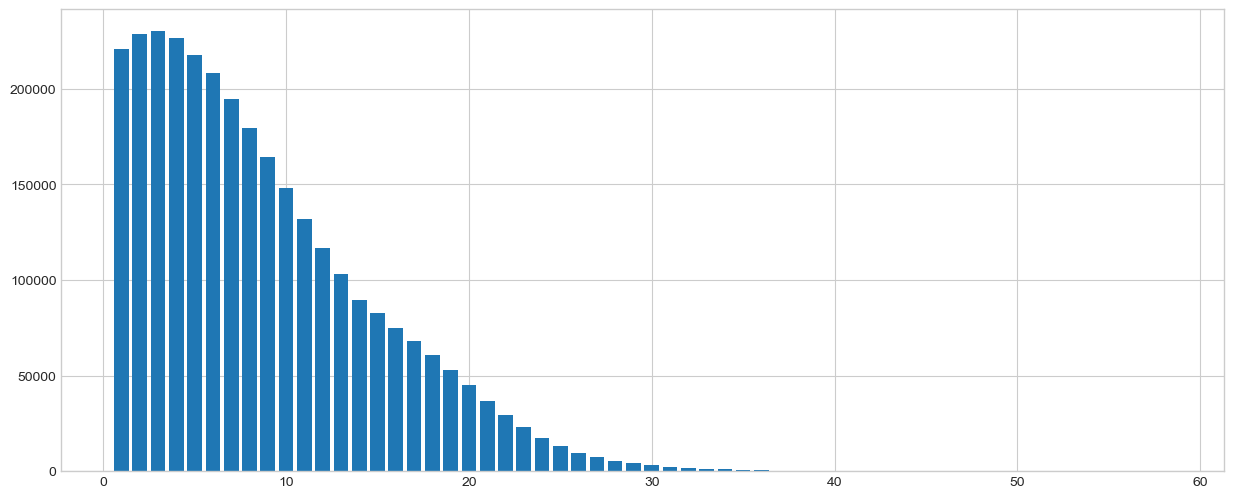

In [28]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
ax.bar(train_len_counter.index.values, train_len_counter.values)

<BarContainer object of 50 artists>

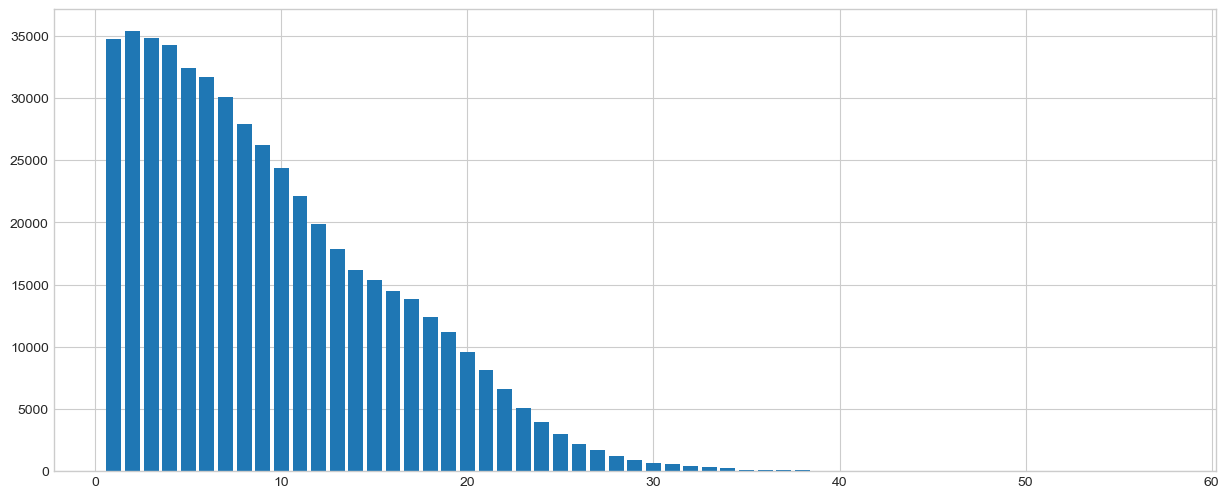

In [29]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
ax.bar(test_len_counter.index.values, test_len_counter.values)

In [30]:
train_lens.max(), test_lens.max()

(np.int64(58), np.int64(57))

* Один из аргументов в функции `dataset_preprocessing_utils.create_padded_buckets` &ndash; `bucket_info` &ndash; словарь, где для конкретной длины последовательности указано до какой длины нужно делать паддинг. Для данного бэйзлайна возьмем простое разбиение на 43 бакета: 
| Длина последовательности | Длина после паддинга |
| :-: | :-: 
| 1 &ndash; 40 | без изменений |
| 41 &ndash; 45 | 45 |
| 46 &ndash; 50 | 50 |
| 51 &ndash; 58 | 58 |

In [31]:
keys_ = list(range(1, 59)) 
lens_ = list(range(1, 41)) + [45] * 5 + [50] * 5 + [58] * 8
bucket_info = dict(zip(keys_, lens_))
bucket_info

{1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36,
 37: 37,
 38: 38,
 39: 39,
 40: 40,
 41: 45,
 42: 45,
 43: 45,
 44: 45,
 45: 45,
 46: 50,
 47: 50,
 48: 50,
 49: 50,
 50: 50,
 51: 58,
 52: 58,
 53: 58,
 54: 58,
 55: 58,
 56: 58,
 57: 58,
 58: 58}

* Так же рассмотрим уникальные значения признаков

In [32]:
for feat, uniq in uniques.items():
    print(f"Feature: {feat}, unique values: {uniq}")

Feature: pre_since_opened, unique values: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19)}
Feature: pre_since_confirmed, unique values: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17)}
Feature: pre_pterm, unique values: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17)}
Feature: pre_fterm, unique values: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int6

* Поскольку паддинг будет производиться нулями, а категориальные признаки закодированы, начиная с 0, перед паддингом будем сдвигать все значения на 1.

* Вся описанная выше предобработка данных реализована в виде функции `create_buckets_from_credits`:

In [33]:
def create_buckets_from_credits(path_to_dataset, bucket_info, save_to_path, frame_with_ids = None, 
                                num_parts_to_preprocess_at_once: int = 1, 
                                num_parts_total=50, has_target=False):
    block = 0
    for step in tqdm.notebook.tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                     desc="Preparing credit data"):
        credits_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once, verbose=True)
        credits_frame.loc[:, features] += 1       
        seq = transform_credits_to_sequences(credits_frame)
        print("Transforming credits to sequences is done.")
        
        if frame_with_ids is not None:
            seq = seq.merge(frame_with_ids, on="id")

        block_as_str = str(block)
        if len(block_as_str) == 1:
            block_as_str = "00" + block_as_str
        else:
            block_as_str = "0" + block_as_str
            
        processed_fragment =  create_padded_buckets(seq, bucket_info=bucket_info, has_target=has_target, 
                                                    save_to_file_path=os.path.join(save_to_path, 
                                                                                   f"processed_chunk_{block_as_str}.pkl"))
        block += 1

* Разобьем обучающие данные на тренировочную и валидационную выборки. Воспользуемся самым простым способом &ndash; для валидации случайным образом выберем 10% обучающих данных.

In [34]:
train, val = train_test_split(train_target, random_state=42, test_size=0.1)
train.shape, val.shape

((2700000, 2), (300000, 2))

In [35]:
TRAIN_BUCKETS_PATH = "data/train_buckets_rnn"
VAL_BUCKETS_PATH = "data/val_buckets_rnn"
TEST_BUCKETS_PATH = "data/test_buckets_rnn"

In [36]:
import shutil

for buckets_path in [TRAIN_BUCKETS_PATH, VAL_BUCKETS_PATH, TEST_BUCKETS_PATH]:
    if os.path.exists(buckets_path):
        print(f"Удаляю папку {buckets_path}")
        shutil.rmtree(buckets_path)  # Удаляем директорию и её содержимое
    print(f"Создаю папку {buckets_path}")
    os.makedirs(buckets_path)  # Создаём директорию

Удаляю папку data/train_buckets_rnn
Создаю папку data/train_buckets_rnn
Удаляю папку data/val_buckets_rnn
Создаю папку data/val_buckets_rnn
Удаляю папку data/test_buckets_rnn
Создаю папку data/test_buckets_rnn


In [37]:
%%time
create_buckets_from_credits(TRAIN_DATA_PATH,
                            bucket_info=bucket_info,
                            save_to_path=TRAIN_BUCKETS_PATH,
                            frame_with_ids=train,
                            num_parts_to_preprocess_at_once=3, 
                            num_parts_total=12, has_target=True)

dataset_train = sorted([os.path.join(TRAIN_BUCKETS_PATH, x) for x in os.listdir(TRAIN_BUCKETS_PATH)])
dataset_train

Preparing credit data:   0%|          | 0/4 [00:00<?, ?it/s]

Reading chunks:
credit/data/train_data/train_data_0.pq
credit/data/train_data/train_data_1.pq
credit/data/train_data/train_data_2.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
credit/data/train_data/train_data_3.pq
credit/data/train_data/train_data_4.pq
credit/data/train_data/train_data_5.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
credit/data/train_data/train_data_6.pq
credit/data/train_data/train_data_7.pq
credit/data/train_data/train_data_8.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
credit/data/train_data/train_data_9.pq
credit/data/train_data/train_data_10.pq
credit/data/train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

CPU times: total: 6min 40s
Wall time: 5min 29s


['data/train_buckets_rnn\\processed_chunk_000.pkl',
 'data/train_buckets_rnn\\processed_chunk_001.pkl',
 'data/train_buckets_rnn\\processed_chunk_002.pkl',
 'data/train_buckets_rnn\\processed_chunk_003.pkl']

In [38]:
%%time
create_buckets_from_credits(TRAIN_DATA_PATH,
                            bucket_info=bucket_info,
                            save_to_path=VAL_BUCKETS_PATH,
                            frame_with_ids=val,
                            num_parts_to_preprocess_at_once=3, 
                            num_parts_total=12, has_target=True)

dataset_val = sorted([os.path.join(VAL_BUCKETS_PATH, x) for x in os.listdir(VAL_BUCKETS_PATH)])
dataset_val

Preparing credit data:   0%|          | 0/4 [00:00<?, ?it/s]

Reading chunks:
credit/data/train_data/train_data_0.pq
credit/data/train_data/train_data_1.pq
credit/data/train_data/train_data_2.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
credit/data/train_data/train_data_3.pq
credit/data/train_data/train_data_4.pq
credit/data/train_data/train_data_5.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
credit/data/train_data/train_data_6.pq
credit/data/train_data/train_data_7.pq
credit/data/train_data/train_data_8.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
credit/data/train_data/train_data_9.pq
credit/data/train_data/train_data_10.pq
credit/data/train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

CPU times: total: 5min 56s
Wall time: 4min 51s


['data/val_buckets_rnn\\processed_chunk_000.pkl',
 'data/val_buckets_rnn\\processed_chunk_001.pkl',
 'data/val_buckets_rnn\\processed_chunk_002.pkl',
 'data/val_buckets_rnn\\processed_chunk_003.pkl']

In [39]:
%%time
create_buckets_from_credits(TEST_DATA_PATH,
                            bucket_info=bucket_info,
                            save_to_path=TEST_BUCKETS_PATH, num_parts_to_preprocess_at_once=2, 
                            num_parts_total=2)

dataset_test = sorted([os.path.join(TEST_BUCKETS_PATH, x) for x in os.listdir(TEST_BUCKETS_PATH)])
dataset_test

Preparing credit data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
credit/data/test_data/test_data_0.pq
credit/data/test_data/test_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

CPU times: total: 1min 3s
Wall time: 51.8 s


['data/test_buckets_rnn\\processed_chunk_000.pkl']

### 2. Modeling

In [40]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
print('Using device:', device)

Using device: cuda


* Для создания модели будем использовать фреймворк `torch`. В нем есть все, чтобы писать произвольные сложные архитектуры и быстро экспериментировать. Для того, чтобы мониторить и логировать весь процесс во время обучения сетей, рекомендуется использовать надстройки над данным фреймворком, например, `lightning`.

* В бейзлайне мы предлагаем базовые компоненты, чтобы можно было обучать нейронную сеть и отслеживать ее качество. Для этого вам предоставлены следующие функции:
    * `data_generators.batches_generator` &ndash; функция-генератор, итеративно возвращает батчи, поддерживает батчи для `tensorflow.keras` и `torch.nn.Module` моделей. В зависимости от флага `is_train` может быть использована для генерации батчей на train/val/test стадии.
    * функция `pytorch_training.train_epoch` &ndash; обучает модель одну эпоху.
    * функция `pytorch_training.eval_model` &ndash; проверяет качество модели на отложенной выборке и возвращает roc_auc_score.
    * функция `pytorch_training.inference` &ndash; делает предикты на новых данных и готовит фрейм для проверяющей системы.
    * класс `training_aux.EarlyStopping` &ndash; реализует early_stopping, сохраняя лучшую модель. Пример использования приведен ниже.

In [41]:
from credit.data_generators import batches_generator
from credit.pytorch_training import train_epoch, eval_model, inference
from credit.training_aux import EarlyStopping

* Все признаки, описывающие кредитную историю клиентов &ndash; категориальные. Для их представления в модели используем категориальные эмбеддинги. Для этого нужно каждому категориальному признаку задать размерность латентного пространства. Используем [формулу](https://forums.fast.ai/t/size-of-embedding-for-categorical-variables/42608) из библиотеки `fast.ai`.

In [42]:
def compute_embed_dim(n_cat: int) -> int:
    return min(600, round(1.6 * n_cat**0.56))

In [43]:
embedding_projections = {feat: (max(uniq)+1, compute_embed_dim(max(uniq)+1)) for feat, uniq in uniques.items()}
embedding_projections

{'pre_since_opened': (np.int64(20), 9),
 'pre_since_confirmed': (np.int64(18), 8),
 'pre_pterm': (np.int64(18), 8),
 'pre_fterm': (np.int64(17), 8),
 'pre_till_pclose': (np.int64(17), 8),
 'pre_till_fclose': (np.int64(16), 8),
 'pre_loans_credit_limit': (np.int64(20), 9),
 'pre_loans_next_pay_summ': (np.int64(8), 5),
 'pre_loans_outstanding': (np.int64(6), 4),
 'pre_loans_total_overdue': (np.int64(2), 2),
 'pre_loans_max_overdue_sum': (np.int64(4), 3),
 'pre_loans_credit_cost_rate': (np.int64(14), 7),
 'pre_loans5': (np.int64(18), 8),
 'pre_loans530': (np.int64(20), 9),
 'pre_loans3060': (np.int64(10), 6),
 'pre_loans6090': (np.int64(6), 4),
 'pre_loans90': (np.int64(20), 9),
 'is_zero_loans5': (np.int64(2), 2),
 'is_zero_loans530': (np.int64(2), 2),
 'is_zero_loans3060': (np.int64(2), 2),
 'is_zero_loans6090': (np.int64(2), 2),
 'is_zero_loans90': (np.int64(2), 2),
 'pre_util': (np.int64(20), 9),
 'pre_over2limit': (np.int64(20), 9),
 'pre_maxover2limit': (np.int64(20), 9),
 'is_zero_

* Реализуем модель. Все входные признаки представим в виде эмбеддингов, сконкатенируем, чтобы получить векторное представление транзакции. Подадим последовательности в `GRU` рекуррентный слой. Используем последнее скрытое состояние в качестве выхода слоя. На основе такого входа построим небольшой `MLP`, выступающий классификатором для целевой задачи. Используем градиентный спуск, чтобы решить оптимизационную задачу.

In [44]:
class RNN_GRU(nn.Module):
    def __init__(self, features, embedding_projections, rnn_units=128, top_classifier_units=32, bidirectional=False, num_layers=1, dropout = 0.0):
        super(RNN_GRU, self).__init__()
       
        self._credits_cat_embeddings = nn.ModuleList([
            self._create_embedding_projection(*embedding_projections[feature])
            for feature in features
        ])
        self._gru = nn.GRU(input_size=sum([embedding_projections[x][1] for x in features]),
                            hidden_size=rnn_units,
                            batch_first=True,
                            bidirectional=bidirectional,
                            num_layers=num_layers,
                            dropout = dropout)
        self._hidden_size = rnn_units * (2 if bidirectional else 1)
        self._top_classifier = nn.Linear(in_features=self._hidden_size, out_features=top_classifier_units)
        self._intermediate_activation = nn.ReLU()
        self._head = nn.Linear(in_features=top_classifier_units, out_features=1)
        
    def forward(self, features):
        batch_size = features[0].shape[0]
        embeddings = [embedding(features[i]) for i, embedding in enumerate(self._credits_cat_embeddings)]
        concated_embeddings = torch.cat(embeddings, dim=-1)
        
        _, last_hidden = self._gru(concated_embeddings)
        hidden = last_hidden.permute(1, 2, 0)
        hidden = torch.reshape(hidden, (batch_size, self._hidden_size))
        
        classification_hidden = self._top_classifier(hidden)
        activation = self._intermediate_activation(classification_hidden)
        raw_output = self._head(activation)
        return raw_output
        
    @classmethod
    def _create_embedding_projection(cls, cardinality, embed_size, add_missing=True, padding_idx=0):
        add_missing = 1 if add_missing else 0
        return nn.Embedding(num_embeddings=cardinality + add_missing, embedding_dim=embed_size, padding_idx=padding_idx)


In [45]:
class RNN_LSTM(nn.Module):
    def __init__(self, features, embedding_projections, rnn_units=128, top_classifier_units=32, bidirectional=False, num_layers=1, dropout = 0.0):
        super(RNN_LSTM, self).__init__()
       
        self._credits_cat_embeddings = nn.ModuleList([
            self._create_embedding_projection(*embedding_projections[feature])
            for feature in features
        ])
        input_size = sum([embedding_projections[x][1] for x in features])
        self._lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=rnn_units,
            batch_first=True,
            bidirectional=bidirectional,
            num_layers=num_layers,
            dropout = dropout
        )
        
        self._hidden_size = rnn_units * (2 if bidirectional else 1)
        self._top_classifier = nn.Linear(in_features=self._hidden_size, out_features=top_classifier_units)
        self._intermediate_activation = nn.ReLU()
        self._head = nn.Linear(in_features=top_classifier_units, out_features=1)
        
    def forward(self, features):
        batch_size = features[0].shape[0]
        embeddings = [embedding(features[i]) for i, embedding in enumerate(self._credits_cat_embeddings)]
        concated_embeddings = torch.cat(embeddings, dim=-1)
        
        _, (hidden, _) = self._lstm(concated_embeddings)
        hidden = hidden.permute(1, 2, 0)
        hidden = torch.reshape(hidden, (batch_size, self._hidden_size))
        
        classification_hidden = self._top_classifier(hidden)
        activation = self._intermediate_activation(classification_hidden)
        raw_output = self._head(activation)
        return raw_output
        
    @classmethod
    def _create_embedding_projection(cls, cardinality, embed_size, add_missing=True, padding_idx=0):
        add_missing = 1 if add_missing else 0
        return nn.Embedding(num_embeddings=cardinality + add_missing, embedding_dim=embed_size, padding_idx=padding_idx)


In [46]:
class RNN_RNN(nn.Module):
    def __init__(self, features, embedding_projections,
                 rnn_units=128, top_classifier_units=32,
                 bidirectional=False, num_layers=1, dropout = 0.0):
        super(RNN_RNN, self).__init__()
       
        # Проекции эмбеддингов для категориальных признаков
        self._credits_cat_embeddings = nn.ModuleList([
            self._create_embedding_projection(*embedding_projections[feature])
            for feature in features
        ])
        
        # Размер входа в RNN — сумма всех размеров эмбеддингов
        input_size = sum(embedding_projections[x][1] for x in features)
        
        # RNN вместо LSTM
        self._rnn = nn.RNN(
            input_size=input_size,
            hidden_size=rnn_units,
            batch_first=True,
            bidirectional=bidirectional,
            num_layers=num_layers,
            dropout = dropout
        )
        
        # Итоговый размер скрытого состояния (учитываем направление)
        self._hidden_size = rnn_units * (2 if bidirectional else 1)
        
        # Верхний классификатор
        self._top_classifier = nn.Linear(self._hidden_size, top_classifier_units)
        self._intermediate_activation = nn.ReLU()
        self._head = nn.Linear(top_classifier_units, 1)
        
    def forward(self, features):
        # features — список тензоров [batch, seq_len] по каждому категориальному фичеру
        batch_size = features[0].shape[0]
        
        # Собираем эмбеддинги и конкатенируем по последнему измерению
        embeds = [emb(features[i]) for i, emb in enumerate(self._credits_cat_embeddings)]
        x = torch.cat(embeds, dim=-1)  # [batch, seq_len, input_size]
        
        # Прогоняем через RNN
        # output: [batch, seq_len, hidden_size * num_directions]
        # hidden: [num_layers * num_directions, batch, hidden_size]
        _, hidden = self._rnn(x)
        
        # Переставляем оси и разворачиваем скрытое состояние
        hidden = hidden.permute(1, 2, 0)            # [batch, hidden_size * num_directions, num_layers]
        hidden = hidden.reshape(batch_size, self._hidden_size)
        
        # Классификатор
        h = self._top_classifier(hidden)
        h = self._intermediate_activation(h)
        out = self._head(h)
        return out
        
    @classmethod
    def _create_embedding_projection(cls, cardinality, embed_size,
                                     add_missing=True, padding_idx=0):
        add_missing = 1 if add_missing else 0
        return nn.Embedding(
            num_embeddings=cardinality + add_missing,
            embedding_dim=embed_size,
            padding_idx=padding_idx
        )


### 3. Training

In [47]:
shutil.rmtree('./checkpoints/', ignore_errors=True)
os.makedirs('./checkpoints/', exist_ok=True)

* Запустим цикл обучения, каждую эпоху будем логировать лосс, а так же ROC-AUC на валидации и на обучении. Будем сохрнаять веса после каждой эпохи, а так же лучшие с помощью early_stopping.

In [48]:

def train_model(model, optimizer, dataset_train, dataset_val, num_epochs, 
                train_batch_size, val_batch_size, path_to_checkpoints, es, device):
    """
    Обучает модель, отслеживая значения ROC AUC для тренировки и валидации.

    Возвращает:
      best_model_path (str): путь к лучшей модели по валидационному ROC AUC.
      best_roc_auc (float): наилучшее значение ROC AUC на валидационной выборке.
      train_roc_auc_list (list): список ROC AUC на тренировке по эпохам.
      val_roc_auc_list (list): список ROC AUC на валидации по эпохам.
    """
    best_roc_auc = -float("inf")
    best_model_path = None
    train_roc_auc_list = []
    val_roc_auc_list = []
    
    for epoch in trange(num_epochs, desc="Training Epochs", unit="epoch", leave=True):
        # Обучаем модель на тренировочном датасете
        train_epoch(model, optimizer, dataset_train, batch_size=train_batch_size, 
                    shuffle=True, print_loss_every_n_batches=500, device=device)
        
        # Оцениваем модель на валидационном датасете
        current_val_roc_auc = eval_model(model, dataset_val, batch_size=val_batch_size, device=device)
        val_roc_auc_list.append(current_val_roc_auc)
        
        # Оцениваем модель на тренировочном датасете (для контроля переобучения)
        current_train_roc_auc = eval_model(model, dataset_train, batch_size=val_batch_size, device=device)
        train_roc_auc_list.append(current_train_roc_auc)
        
        #print(f"Epoch {epoch+1} completed. Train ROC AUC: {current_train_roc_auc}, Val ROC AUC: {current_val_roc_auc}")
       
        es(current_val_roc_auc, model)
        if es.early_stop:
            print("Early stopping reached. Stop training...")
            break
        
        # Сохраняем чекпоинт текущей эпохи (для истории)
        checkpoint_path = os.path.join(path_to_checkpoints, f"epoch_{epoch+1}_val_{current_val_roc_auc:.3f}.pt")
        torch.save(model.state_dict(), checkpoint_path)
    
    #print(f"Training finished. Best model saved at: {best_model_path} with Val ROC AUC: {best_roc_auc}")
    
    return best_model_path, best_roc_auc, train_roc_auc_list, val_roc_auc_list


In [49]:
experiment_configs = [
    {
        "name": "exp_RNN_adam_lr_001_rnn_units128_tpu32_bd0",
        "model_name": RNN_RNN,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 128,
            "top_classifier_units": 32,
            "bidirectional": False,
            "num_layers": 1,
            "dropout":0.0
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_RNN_adam_lr_001_rnn_units64_tpu32_bd0",
        "model_name": RNN_RNN,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 64,
            "top_classifier_units": 32,
            "bidirectional": False,
            "num_layers": 1,
            "dropout":0.0
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_RNN_adam_lr_001_rnn_units128_tpu32_bd1",
        "model_name": RNN_RNN,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 128,
            "top_classifier_units": 32,
            "bidirectional": True,
            "num_layers": 1,
            "dropout":0.0
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_RNN_adam_lr_001_rnn_units128_tpu32_bd0_dp2",
        "model_name": RNN_RNN,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 128,
            "top_classifier_units": 32,
            "bidirectional": False,
            "num_layers": 1,
            "dropout":0.2
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_RNN_adam_lr_001_rnn_units128_tpu32_bd0_dp5",
        "model_name": RNN_RNN,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 128,
            "top_classifier_units": 32,
            "bidirectional": False,
            "num_layers": 1,
            "dropout":0.5
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_GRU_adam_lr_001_rnn_units64_tpu32_bd0_dp0_nl1",
        "model_name": RNN_GRU,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 64,
            "top_classifier_units": 32,
            "bidirectional": False,
            "num_layers": 1,
            "dropout":0.0
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_GRU_adam_lr_001_rnn_units64_tpu32_bd0_dp2_nl1",
        "model_name": RNN_GRU,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 64,
            "top_classifier_units": 32,
            "bidirectional": False,
            "num_layers": 1,
            "dropout":0.2
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_GRU_adam_lr_001_rnn_units64_tpu32_bd0_dp0_nl1",
        "model_name": RNN_GRU,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 64,
            "top_classifier_units": 32,
            "bidirectional": False,
            "num_layers": 1,
            "dropout":0.5
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_GRU_adam_lr_001_rnn_units64_tpu32_bd1_dp5_nl1",
        "model_name": RNN_GRU,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 64,
            "top_classifier_units": 32,
            "bidirectional": True,
            "num_layers": 1,
            "dropout":0.5
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_LSTM_adam_lr_001_rnn_units64_tpu32_bd0_dp0_nl1",
        "model_name": RNN_LSTM,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 64,
            "top_classifier_units": 32,
            "bidirectional": False,
            "num_layers": 1,
            "dropout":0.0
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_LSTM_adam_lr_001_rnn_units64_tpu32_bd1_dp0_nl1",
        "model_name": RNN_LSTM,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 64,
            "top_classifier_units": 32,
            "bidirectional": True,
            "num_layers": 1,
            "dropout":0.0
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_LSTM_adam_lr_001_rnn_units64_tpu32_bd1_dp5_nl1",
        "model_name": RNN_LSTM,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 64,
            "top_classifier_units": 32,
            "bidirectional": True,
            "num_layers": 1,
            "dropout":0.5
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_LSTM_adam_lr_001_rnn_units64_tpu32_bd1_dp5_nl2",
        "model_name": RNN_LSTM,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 64,
            "top_classifier_units": 32,
            "bidirectional": True,
            "num_layers": 2,
            "dropout":0.5
            },
        "early_stopping_patience": 3
    },
    
    
]

In [50]:
print(len(experiment_configs))

13


In [51]:
experiment_results = []

for config in tqdm.tqdm(experiment_configs, desc="Experiments", unit="experiment"):
    print(f"\n{'='*40}\nStarting experiment: {config['name']}")
    
    checkpoint_dir = os.path.join("checkpoints", config["name"])
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Создание модели через передачу класса
    model = config["model_name"](**config["model_params"])
    model.to(device)
    
    # Настройка оптимизатора
    optimizer_name = config["optimizer"].lower()
    if optimizer_name == "adam":
        optimizer = torch.optim.Adam(model.parameters(),**config["optimizer_params"])
    elif optimizer_name == "sgd":
        optimizer = torch.optim.SGD(model.parameters(),**config["optimizer_params"])
    elif optimizer_name == 'adamw':
        optimizer = torch.optim.AdamW(model.parameters(),**config["optimizer_params"])
    else:
        raise ValueError(f"Неизвестный оптимизатор: {config['optimizer']}")
    
    # Создание объекта ранней остановки
    es = EarlyStopping(patience=config.get("early_stopping_patience", 3), verbose=False)
    
    # Запуск обучения
    best_model_path, best_roc_auc, train_roc_auc_list, val_roc_auc_list = train_model(
        model=model,
        optimizer=optimizer,
        dataset_train=dataset_train,
        dataset_val=dataset_val,
        num_epochs=config["num_epochs"],
        train_batch_size=config["train_batch_size"],
        val_batch_size=config["val_batch_size"],
        path_to_checkpoints=checkpoint_dir,
        es=es,
        device=device
    )
    
    print(f"Experiment {config['name']} finished. Best model saved at: {best_model_path}")
    
    experiment_results.append({
        "experiment": config["name"],
        "model_name": config["model_name"].__name__,  # Получаем имя класса модели
        "optimizer": config["optimizer"],
        "optimizer_params": config["optimizer_params"],
        "num_epochs": config["num_epochs"],
        "train_batch_size": config["train_batch_size"],
        "val_batch_size": config["val_batch_size"],
        "model_params": config["model_params"],
        "early_stopping_patience": config.get("early_stopping_patience", 3),
        "best_model_path": best_model_path,
        "best_roc_auc": best_roc_auc,
        "train_roc_auc": train_roc_auc_list,
        "val_roc_auc": val_roc_auc_list,
    })



Experiments:   0%|          | 0/13 [00:00<?, ?experiment/s]


Starting experiment: exp_RNN_adam_lr_001_rnn_units128_tpu32_bd0


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.764597. Current best: -0.748413
EarlyStopping counter: 1 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.766076. Current best: -0.748413
EarlyStopping counter: 2 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Experiments:   8%|▊         | 1/13 [21:13<4:14:37, 1273.09s/experiment]

No imporvement in validation metric. Current: -0.766554. Current best: -0.748413
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
Experiment exp_RNN_adam_lr_001_rnn_units128_tpu32_bd0 finished. Best model saved at: None

Starting experiment: exp_RNN_adam_lr_001_rnn_units64_tpu32_bd0


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.756783. Current best: -0.753441
EarlyStopping counter: 1 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.761400. Current best: -0.753441
EarlyStopping counter: 2 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Experiments:  15%|█▌        | 2/13 [37:37<3:22:16, 1103.34s/experiment]

No imporvement in validation metric. Current: -0.763519. Current best: -0.753441
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
Experiment exp_RNN_adam_lr_001_rnn_units64_tpu32_bd0 finished. Best model saved at: None

Starting experiment: exp_RNN_adam_lr_001_rnn_units128_tpu32_bd1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.766288. Current best: -0.757879
EarlyStopping counter: 1 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.764490. Current best: -0.757879
EarlyStopping counter: 2 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Experiments:  23%|██▎       | 3/13 [59:10<3:18:17, 1189.74s/experiment]c:\Users\AltSp\.conda\envs\pytorch_env\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


No imporvement in validation metric. Current: -0.768627. Current best: -0.757879
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
Experiment exp_RNN_adam_lr_001_rnn_units128_tpu32_bd1 finished. Best model saved at: None

Starting experiment: exp_RNN_adam_lr_001_rnn_units128_tpu32_bd0_dp2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.752097. Current best: -0.751061
EarlyStopping counter: 1 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.762991. Current best: -0.751061
EarlyStopping counter: 2 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Experiments:  31%|███       | 4/13 [1:16:40<2:50:13, 1134.85s/experiment]c:\Users\AltSp\.conda\envs\pytorch_env\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


No imporvement in validation metric. Current: -0.765841. Current best: -0.751061
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
Experiment exp_RNN_adam_lr_001_rnn_units128_tpu32_bd0_dp2 finished. Best model saved at: None

Starting experiment: exp_RNN_adam_lr_001_rnn_units128_tpu32_bd0_dp5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.761647. Current best: -0.752674
EarlyStopping counter: 1 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.764308. Current best: -0.752674
EarlyStopping counter: 2 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Experiments:  38%|███▊      | 5/13 [1:34:10<2:27:13, 1104.23s/experiment]

No imporvement in validation metric. Current: -0.767237. Current best: -0.752674
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
Experiment exp_RNN_adam_lr_001_rnn_units128_tpu32_bd0_dp5 finished. Best model saved at: None

Starting experiment: exp_GRU_adam_lr_001_rnn_units64_tpu32_bd0_dp0_nl1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.773638. Current best: -0.768031
EarlyStopping counter: 1 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.775281. Current best: -0.768031
EarlyStopping counter: 2 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Experiments:  46%|████▌     | 6/13 [1:51:48<2:06:58, 1088.36s/experiment]c:\Users\AltSp\.conda\envs\pytorch_env\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


No imporvement in validation metric. Current: -0.776831. Current best: -0.768031
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
Experiment exp_GRU_adam_lr_001_rnn_units64_tpu32_bd0_dp0_nl1 finished. Best model saved at: None

Starting experiment: exp_GRU_adam_lr_001_rnn_units64_tpu32_bd0_dp2_nl1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.770950. Current best: -0.765655
EarlyStopping counter: 1 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.771131. Current best: -0.765655
EarlyStopping counter: 2 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Experiments:  54%|█████▍    | 7/13 [2:09:22<1:47:42, 1077.05s/experiment]c:\Users\AltSp\.conda\envs\pytorch_env\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


No imporvement in validation metric. Current: -0.774627. Current best: -0.765655
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
Experiment exp_GRU_adam_lr_001_rnn_units64_tpu32_bd0_dp2_nl1 finished. Best model saved at: None

Starting experiment: exp_GRU_adam_lr_001_rnn_units64_tpu32_bd0_dp0_nl1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.771163. Current best: -0.767215
EarlyStopping counter: 1 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.774035. Current best: -0.767215
EarlyStopping counter: 2 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Experiments:  62%|██████▏   | 8/13 [2:27:05<1:29:23, 1072.75s/experiment]c:\Users\AltSp\.conda\envs\pytorch_env\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


No imporvement in validation metric. Current: -0.773946. Current best: -0.767215
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
Experiment exp_GRU_adam_lr_001_rnn_units64_tpu32_bd0_dp0_nl1 finished. Best model saved at: None

Starting experiment: exp_GRU_adam_lr_001_rnn_units64_tpu32_bd1_dp5_nl1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.772397. Current best: -0.767395
EarlyStopping counter: 1 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.776713. Current best: -0.767395
EarlyStopping counter: 2 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Experiments:  69%|██████▉   | 9/13 [2:44:58<1:11:30, 1072.64s/experiment]

No imporvement in validation metric. Current: -0.778331. Current best: -0.767395
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
Experiment exp_GRU_adam_lr_001_rnn_units64_tpu32_bd1_dp5_nl1 finished. Best model saved at: None

Starting experiment: exp_LSTM_adam_lr_001_rnn_units64_tpu32_bd0_dp0_nl1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.771363. Current best: -0.764095
EarlyStopping counter: 1 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.773504. Current best: -0.764095
EarlyStopping counter: 2 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Experiments:  77%|███████▋  | 10/13 [3:02:32<53:21, 1067.17s/experiment] 

No imporvement in validation metric. Current: -0.773903. Current best: -0.764095
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
Experiment exp_LSTM_adam_lr_001_rnn_units64_tpu32_bd0_dp0_nl1 finished. Best model saved at: None

Starting experiment: exp_LSTM_adam_lr_001_rnn_units64_tpu32_bd1_dp0_nl1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.767392. Current best: -0.766127
EarlyStopping counter: 1 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.775947. Current best: -0.766127
EarlyStopping counter: 2 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Experiments:  85%|████████▍ | 11/13 [3:20:40<35:47, 1073.51s/experiment]c:\Users\AltSp\.conda\envs\pytorch_env\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


No imporvement in validation metric. Current: -0.774838. Current best: -0.766127
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
Experiment exp_LSTM_adam_lr_001_rnn_units64_tpu32_bd1_dp0_nl1 finished. Best model saved at: None

Starting experiment: exp_LSTM_adam_lr_001_rnn_units64_tpu32_bd1_dp5_nl1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.773550. Current best: -0.766692
EarlyStopping counter: 1 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation metric. Current: -0.770667. Current best: -0.766692
EarlyStopping counter: 2 out of 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Experiments:  92%|█████████▏| 12/13 [3:38:39<17:55, 1075.16s/experiment]

No imporvement in validation metric. Current: -0.773837. Current best: -0.766692
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
Experiment exp_LSTM_adam_lr_001_rnn_units64_tpu32_bd1_dp5_nl1 finished. Best model saved at: None

Starting experiment: exp_LSTM_adam_lr_001_rnn_units64_tpu32_bd1_dp5_nl2


Training: 0it [00:00, ?it/s]

Experiments:  92%|█████████▏| 12/13 [3:38:40<18:13, 1093.36s/experiment]


RuntimeError: shape '[128, 128]' is invalid for input of size 32768

In [ ]:
# --- Сохранение результатов в DataFrame ---
df_results = pd.DataFrame(experiment_results)
df_results

In [ ]:
df_results.to_csv('experiments_relults.csv', index=False, encoding='utf-8')